# GCT to X-ID

What is the relationship between accuracy on the galaxy classification task (GCT) and accuracy on the cross-identification task?

In [7]:
import sys

import astropy.coordinates
import h5py, astropy.io.ascii as asc
import numpy
import scipy.stats

import pipeline

# Try to set up matplotlib fonts.
import matplotlib

# http://bkanuka.com/articles/native-latex-plots/
def figsize(scale):
    fig_width_pt = 240.0
    inches_per_pt = 1.0/72.27
    golden_mean = (numpy.sqrt(5.0)-1.0)/2.0
    fig_width = fig_width_pt*inches_per_pt*scale
    fig_height = fig_width*golden_mean
    fig_size = [fig_width,fig_height]
    return fig_size

pgf_with_latex = {
    "pgf.texsystem": "pdflatex",
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": [],
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "figure.figsize": figsize(0.9),
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",
        r"\usepackage[T1]{fontenc}",
    ]
}
matplotlib.rcParams.update(pgf_with_latex)

swire_names_cdfs, swire_coords_cdfs, swire_features_cdfs = pipeline.generate_swire_features(field='cdfs')
swire_names_elais, swire_coords_elais, swire_features_elais = pipeline.generate_swire_features(field='elais')
swire_labels_cdfs = pipeline.generate_swire_labels(swire_names_cdfs, swire_coords_cdfs, field='cdfs')
swire_labels_elais = pipeline.generate_swire_labels(swire_names_elais, swire_coords_elais, field='elais')
(atlas_train_sets_cdfs, atlas_test_sets_cdfs), (swire_train_sets_cdfs, swire_test_sets_cdfs) = pipeline.generate_data_sets(swire_coords_cdfs, swire_labels_cdfs, field='cdfs')
(atlas_train_sets_elais, atlas_test_sets_elais), (swire_train_sets_elais, swire_test_sets_elais) = pipeline.generate_data_sets(swire_coords_elais, swire_labels_elais, field='elais')

table = asc.read('/Users/alger/data/Crowdastro/one-table-to-rule-them-all.tbl')

FALLOFF_SIGMA = 1 / 120

In [2]:
import scipy.spatial

swire_tree = scipy.spatial.KDTree(swire_coords_cdfs)

In [3]:
swire_name_to_index = {j:i for i, j in enumerate(swire_names_cdfs)}

In [8]:
import sklearn.ensemble, random, crowdastro.crowd.util, numpy, sklearn.metrics

# Generate some classifiers and test them.

bce_losses = []
accs_gct = []
accs_xid = []
quadrants = []
distances = []
cms = []
precisions = []
recalls = []
waucs = []
aucs = []
microaucs = []
saucs = []
n_max = swire_train_sets_cdfs[:, pipeline.SET_NAMES['RGZ & Norris']].sum(axis=0).min()
for size in numpy.logspace(1, numpy.log10(n_max), 40):
    size = int(size)
    print(size)
    for quadrant in range(4):
        rf = sklearn.linear_model.LogisticRegression(class_weight='balanced',
                                                     C=100000.0)
        # Choose a subset.
        train = list(swire_train_sets_cdfs[:, pipeline.SET_NAMES['RGZ & Norris'], quadrant].nonzero()[0])
        random.shuffle(train)
        while not swire_labels_cdfs[train[:size], 0].any():
            random.shuffle(train)
        train = train[:size]
        train_features = swire_features_cdfs[train]
        train_labels = swire_labels_cdfs[train, 0]
        test_features = swire_features_cdfs[swire_test_sets_cdfs[:, pipeline.SET_NAMES['RGZ & Norris'], quadrant]]
        test_labels = swire_labels_cdfs[swire_test_sets_cdfs[:, pipeline.SET_NAMES['RGZ & Norris'], quadrant], 0]
        rf.fit(train_features, train_labels)
        
        # Pick a new threshold that maximises balanced accuracy.
        thresholds = numpy.linspace(0.4, 0.7, 100)
        pred_probs = rf.predict_proba(train_features)[:, 1]
        threshold_bas = []
        for threshold in thresholds:
            try:
                ba = crowdastro.crowd.util.balanced_accuracy(
                    train_labels,
                    pred_probs > threshold)
            except ValueError:
                ba = 0.5
            threshold_bas.append(ba)
        best_threshold = thresholds[numpy.argmax(threshold_bas)]
        
        # Test on SWIRE (GCT).
        pred_labels = rf.predict_proba(test_features)[:, 1] > best_threshold
        pred_probs = rf.predict_proba(test_features)
        waucs.append(sklearn.metrics.roc_auc_score(test_labels, pred_probs[:, 1], average='weighted'))
        aucs.append(sklearn.metrics.roc_auc_score(test_labels, pred_probs[:, 1], average='macro'))
        microaucs.append(sklearn.metrics.roc_auc_score(test_labels, pred_probs[:, 1], average='micro'))
        saucs.append(sklearn.metrics.roc_auc_score(test_labels, pred_probs[:, 1], average='samples'))
        ba = crowdastro.crowd.util.balanced_accuracy(test_labels, pred_labels)
        accs_gct.append(ba)
        n_pos = test_labels.sum()
        n_neg = (~test_labels).sum()
        pos_weights = numpy.ones(shape=test_labels.shape)
        neg_weights = numpy.ones(shape=test_labels.shape) * (n_pos / n_neg)
        bce_loss = sklearn.metrics.log_loss(test_labels, pred_probs,
                                            sample_weight=numpy.where(test_labels, pos_weights, neg_weights))
        bce_losses.append(bce_loss)
        quadrants.append(quadrant)
        precisions.append(sklearn.metrics.precision_score(test_labels, pred_labels))
        recalls.append(sklearn.metrics.recall_score(test_labels, pred_labels))
        cms.append(sklearn.metrics.confusion_matrix(test_labels, pred_labels))
        
        # Test on ATLAS (X-ID).
        n_correct = 0
        n_total = 0
        distances_ = []
        for atlas in atlas_test_sets_cdfs[:, pipeline.SET_NAMES['RGZ & Norris'], quadrant].nonzero()[0]:
            row = table[table['Key'] == atlas][0]
            ra = row['Component RA (Franzen)']
            dec = row['Component DEC (Franzen)']
            swire = row['Source SWIRE (Norris)']
            if not swire.startswith('SWIRE'):
                continue
            nearby = swire_tree.query_ball_point(numpy.array([ra, dec]), 1 / 60)
            nearby_features = swire_features_cdfs[nearby]
            if not nearby:
                continue
            atpreds = rf.predict_proba(nearby_features)[:, 1]
            # Multiply by Gaussians
            scoords = astropy.coordinates.SkyCoord(ra=ra, dec=dec, unit='deg')
            nearby_scoords = astropy.coordinates.SkyCoord(
                ra=swire_coords_cdfs[nearby, 0], dec=swire_coords[nearby, 1], unit='deg')
            separations = numpy.array(scoords.separation(nearby_scoords).deg)
            gaussians = scipy.stats.norm.pdf(separations, scale=FALLOFF_SIGMA)
            atpreds *= gaussians
            names = [swire_names_cdfs[n] for n in nearby]
            name = names[numpy.argmax(atpreds)]
            n_correct += name == swire
            n_total += 1
        accs_xid.append(n_correct / n_total)

10


NameError: name 'swire_coords' is not defined

In [ ]:
n_candidates = []
for q in range(4):
    for atlas in atlas_test_sets_cdfs[:, pipeline.SET_NAMES['RGZ & Norris'], q].nonzero()[0]:
        row = table[table['Key'] == atlas][0]
        ra = row['Component RA (Franzen)']
        dec = row['Component DEC (Franzen)']
        swire = row['Source SWIRE (Norris)']
        if not swire.startswith('SWIRE'):
            continue
        nearby = swire_tree.query_ball_point(numpy.array([ra, dec]), 1 / 60)
        n_candidates.append(len(nearby))

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from scipy.stats import gaussian_kde
def density_scatter(xs, ys, cmap='summer', log=False, **kwargs):
    xy = numpy.vstack([xs, ys])
    z = gaussian_kde(xy)(xy)
    if log:
        z = numpy.log(z)
    plt.scatter(xs, ys, c=z, marker='o', cmap=cmap, **kwargs)

In [ ]:
# plt.scatter(numpy.array(accs_gct) * 100, numpy.array(accs_xid) * 100, marker='+', alpha=0.7,
#             cmap='Set2')
accs_gct_ = numpy.array(accs_gct)
accs_xid_ = numpy.array(accs_xid)
density_scatter(accs_gct_[accs_gct_ > 0.51] * 100, accs_xid_[accs_gct_ > 0.51] * 100)
plt.xlabel('GCT balanced accuracy')
plt.ylabel('X-ID accuracy')
plt.grid(color='lightgrey', axis='y')
plt.savefig('/Users/alger/repos/crowdastro-projects/ATLAS-CDFS/gct-to-xid-lr.pdf')

In [ ]:
density_scatter(numpy.array(bce_losses) * 100, numpy.array(accs_xid) * 100)
plt.xlabel('GCT class-balanced cross-entropy loss')
plt.ylabel('X-ID accuracy')
plt.gca().invert_xaxis()
plt.grid(color='lightgrey', axis='y')

In [ ]:
density_scatter(numpy.array(precisions) * 100, numpy.array(accs_xid) * 100)
plt.xlabel('GCT precision')
plt.ylabel('X-ID accuracy')
plt.grid(color='lightgrey', axis='y')
plt.savefig('/Users/alger/repos/crowdastro-projects/ATLAS-CDFS/gct-to-xid-precision.pdf')

In [ ]:
density_scatter(numpy.array(recalls) * 100, numpy.array(accs_xid) * 100)
plt.xlabel('GCT recall')
plt.ylabel('X-ID accuracy')
plt.grid(color='lightgrey', axis='y')
plt.savefig('/Users/alger/repos/crowdastro-projects/ATLAS-CDFS/gct-to-xid-recall.pdf')

In [ ]:
density_scatter(numpy.array(aucs), numpy.array(accs_xid) * 100)
density_scatter(aucs,
                numpy.mean([numpy.array(aucs) ** (n - 1) for n in n_candidates], axis=0) * 100,
                cmap='winter')
plt.xlabel('GCT AUC')
plt.ylabel('X-ID accuracy')
plt.grid(color='lightgrey', axis='y')
# plt.savefig('/Users/alger/repos/crowdastro-projects/ATLAS-CDFS/gct-to-xid-auc.pdf')

In [ ]:
plt.scatter(numpy.array(recalls), numpy.array(precisions), marker='o', alpha=1, c=quadrants, cmap='Set2')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(color='lightgrey', axis='y')

In [ ]:
plt.scatter(numpy.array(recalls), numpy.array(precisions), marker='+', alpha=0.7)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(color='lightgrey', axis='y')

In [ ]:
len(accs_gct)

In [23]:
# Generate some RF classifiers and test them.

bce_losses_rf = []
accs_gct_rf = []
accs_xid_rf = []
quadrants_rf = []
distances_rf = []
cms_rf = []
precisions_rf = []
recalls_rf = []
aucs_rf = []
n_max = swire_train_sets_cdfs[:, pipeline.SET_NAMES['RGZ & Norris']].sum(axis=0).min()
for size in numpy.logspace(1, numpy.log10(n_max), 40):
    size = int(size)
    print(size)
    for quadrant in range(4):
        rf = sklearn.ensemble.RandomForestClassifier(class_weight='balanced',
                                                     criterion='entropy',
                                                     min_samples_leaf=45)
        # Choose a subset.
        train = list(swire_train_sets_cdfs[:, pipeline.SET_NAMES['RGZ & Norris'], quadrant].nonzero()[0])
        random.shuffle(train)
        while not swire_labels_cdfs[train[:size], 0].any():
            random.shuffle(train)
        train = train[:size]
        train_features = swire_features_cdfs[train]
        train_labels = swire_labels_cdfs[train, 0]
        test_features = swire_features_cdfs[swire_test_sets_cdfs[:, pipeline.SET_NAMES['RGZ & Norris'], quadrant]]
        test_labels = swire_labels_cdfs[swire_test_sets_cdfs[:, pipeline.SET_NAMES['RGZ & Norris'], quadrant], 0]
        rf.fit(train_features, train_labels)
        
        # Test on SWIRE (GCT).
        pred_labels = rf.predict(test_features)
        pred_probs = rf.predict_proba(test_features)
        ba = crowdastro.crowd.util.balanced_accuracy(test_labels, pred_labels)
        aucs_rf.append(sklearn.metrics.roc_auc_score(test_labels, pred_probs[:, 1], average='macro'))
        accs_gct_rf.append(ba)
        n_pos = test_labels.sum()
        n_neg = (~test_labels).sum()
        pos_weights = numpy.ones(shape=test_labels.shape)
        neg_weights = numpy.ones(shape=test_labels.shape) * (n_pos / n_neg)
        bce_loss = sklearn.metrics.log_loss(test_labels, pred_probs,
                                            sample_weight=numpy.where(test_labels, pos_weights, neg_weights))
        bce_losses_rf.append(bce_loss)
        quadrants_rf.append(quadrant)
        precisions_rf.append(sklearn.metrics.precision_score(test_labels, pred_labels))
        recalls_rf.append(sklearn.metrics.recall_score(test_labels, pred_labels))
        cms_rf.append(sklearn.metrics.confusion_matrix(test_labels, pred_labels))
        
        # Test on ATLAS (X-ID).
        n_correct = 0
        n_total = 0
        distances_ = []
        for atlas in atlas_test_sets_cdfs[:, pipeline.SET_NAMES['RGZ & Norris'], quadrant].nonzero()[0]:
            row = table[table['Key'] == atlas][0]
            ra = row['Component RA (Franzen)']
            dec = row['Component DEC (Franzen)']
            swire = row['Source SWIRE (Norris)']
            if not swire.startswith('SWIRE'):
                continue
            nearby = swire_tree.query_ball_point(numpy.array([ra, dec]), 1 / 60)
            nearby_features = swire_features_cdfs[nearby]
            if not nearby:
                continue
            atpreds = rf.predict_proba(nearby_features)[:, 1]
            names = [swire_names_cdfs[n] for n in nearby]
            name = names[numpy.argmax(atpreds)]
            n_correct += name == swire
            n_total += 1
        accs_xid_rf.append(n_correct / n_total)

10


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


11


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


14


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


16


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


19


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


23


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


27


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


32


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


39


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


46


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


54


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


65
77


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


91


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


108


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


128


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


152
181
214
254
302
358
424
503
597
707
839
995
1180
1399
1659
1968
2333
2767
3281
3890
4613
5470
6486
7692


In [35]:
import scipy.stats
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
    accs_gct_[accs_gct_ > 0.51], 
    accs_xid_[accs_gct_ > 0.51])
slope_rf, intercept_rf, r_value_rf, p_value_rf, std_err_rf = scipy.stats.linregress(
    accs_gct_rf_[accs_gct_rf_ > 0.51],
    accs_xid_rf_[accs_gct_rf_ > 0.51])

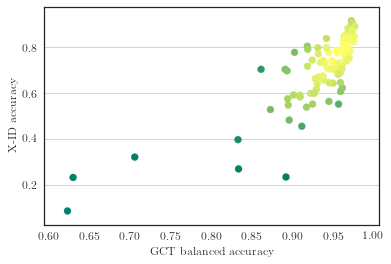

In [29]:
accs_gct_rf_ = numpy.array(accs_gct_rf)
accs_xid_rf_ = numpy.array(accs_xid_rf)
density_scatter(accs_gct_rf_[accs_gct_rf_ > 0.51], accs_xid_rf_[accs_gct_rf_ > 0.51], log=True)
plt.xlabel('GCT balanced accuracy')
plt.ylabel('X-ID accuracy')
plt.grid(color='lightgrey', axis='y')
plt.savefig('/Users/alger/repos/crowdastro-projects/ATLAS-CDFS/images/gct-to-xid-rf.pdf')

In [ ]:
density_scatter(numpy.array(precisions_rf) * 100, numpy.array(accs_xid_rf) * 100, log=True)
plt.xlabel('GCT precision')
plt.ylabel('X-ID accuracy')
plt.grid(color='lightgrey', axis='y')
plt.savefig('/Users/alger/repos/crowdastro-projects/ATLAS-CDFS/gct-to-xid-precision-rf.pdf')

In [ ]:
density_scatter(numpy.array(recalls_rf) * 100, numpy.array(accs_xid_rf) * 100, log=True)
plt.xlabel('GCT recall')
plt.ylabel('X-ID accuracy')
plt.grid(color='lightgrey', axis='y')
plt.savefig('/Users/alger/repos/crowdastro-projects/ATLAS-CDFS/gct-to-xid-recall-rf.pdf')

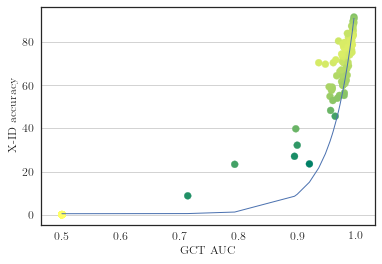

In [31]:
density_scatter(numpy.array(aucs_rf), numpy.array(accs_xid_rf) * 100, log=True)
plt.plot(sorted(aucs_rf),
         numpy.mean([numpy.array(sorted(aucs_rf)) ** (n - 1) for n in n_candidates], axis=0) * 100,
         linewidth=1)
plt.xlabel('GCT AUC')
plt.ylabel('X-ID accuracy')
plt.grid(color='lightgrey', axis='y')
plt.savefig('/Users/alger/repos/crowdastro-projects/ATLAS-CDFS/images/gct-to-xid-auc-rf.pdf')

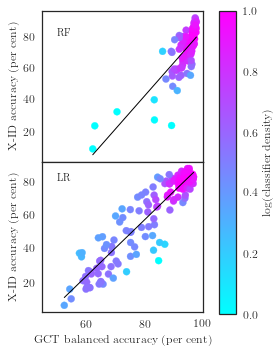

In [39]:
fs = figsize(0.9)
fs = fs[0] * 1.5, fs[1] * 3
fig = plt.figure(figsize=fs)
plt.subplot(2, 1, 1)
density_scatter(
    accs_gct_rf_[accs_gct_rf_ > 0.51] * 100,
    accs_xid_rf_[accs_gct_rf_ > 0.51] * 100, log=True, cmap='cool')
plt.plot(numpy.array(sorted(accs_gct_rf_[accs_gct_rf_ > 0.51])) * 100,
         numpy.array(sorted(accs_gct_rf_[accs_gct_rf_ > 0.51])) * slope_rf * 100 + intercept_rf * 100,
         linewidth=1, color='k')
# plt.hexbin(numpy.array(accs_gct_rf) * 100, numpy.array(accs_xid_rf) * 100, gridsize=15, bins='log')
# plt.scatter(numpy.array(precisions_rf) * 100, numpy.array(accs_xid_rf) * 100, marker='.', alpha=0.7)
plt.ylabel('X-ID accuracy (per cent)')
plt.xticks([])
# plt.grid(color='lightgrey', axis='y')
plt.annotate('RF', (50, 80))
plt.xlim((45, 100))
plt.subplot(2, 1, 2)
density_scatter
density_scatter(accs_gct_[accs_gct_ > 0.51] * 100, accs_xid_[accs_gct_ > 0.51] * 100, log=True, cmap='cool')
plt.plot(numpy.array(sorted(accs_gct_[accs_gct_ > 0.51])) * 100,
         numpy.array(sorted(accs_gct_[accs_gct_ > 0.51])) * slope * 100 + intercept * 100,
         linewidth=1, color='k')
# plt.hexbin(numpy.array(accs_gct) * 100, numpy.array(accs_xid) * 100, gridsize=15, bins='log')
# plt.scatter(numpy.array(precisions) * 100, numpy.array(accs_xid) * 100, marker='.', alpha=0.7)
plt.xlabel('GCT balanced accuracy (per cent)')
plt.ylabel('X-ID accuracy (per cent)')
# plt.grid(color='lightgrey', axis='y')
plt.xlim((45, 100))
plt.annotate('LR', (50, 80))
import matplotlib.cm, matplotlib.colors, matplotlib.colorbar
cbar_ax = fig.add_axes([0.75, 0.12, 0.05, 0.76])
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
cb1 = matplotlib.colorbar.ColorbarBase(cbar_ax,
                                       norm=norm,
                                       orientation='vertical',
                                       cmap='cool')
cb1.set_label('log(classifier density)')
# fig.colorbar(cax=cbar_ax)
plt.subplots_adjust(hspace=0, right=0.7, left=0.2)
plt.savefig('/Users/alger/repos/crowdastro-projects/ATLAS-CDFS/images/gct-to-xid.pdf')

In [40]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(accs_gct_[accs_gct_ > 0.51], accs_xid_[accs_gct_ > 0.51])
slope_rf, intercept_rf, r_value_rf, p_value_rf, std_err_rf = scipy.stats.linregress(accs_gct_rf_[accs_gct_rf_ > 0.51], accs_xid_rf_[accs_gct_rf_ > 0.51])

print(r_value**2, r_value_rf**2)
print(std_err, std_err_rf)

0.854147221028 0.643591167692
0.0558303028281 0.161951456729


6.98469628987 -0.196491891105


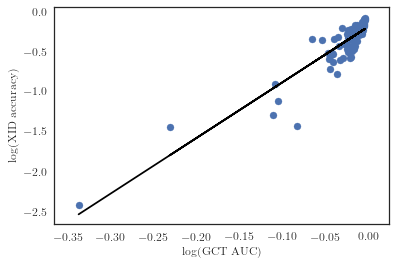

In [60]:
aucs_rf_ = numpy.array(aucs_rf)
xs = numpy.log(aucs_rf_[aucs_rf_ > 0.51])
ys = numpy.log(accs_xid_rf_[aucs_rf_ > 0.51])
plt.scatter(xs, ys)
m, b = numpy.polyfit(xs, ys, 1)
plt.plot(xs, m * xs + b, c='black')
print(m, b)
plt.xlabel('log(GCT AUC)')
plt.ylabel('log(XID accuracy)')
# N = 20
# plt.scatter(xs, numpy.exp(-N / 200) * xs ** N + (1 - numpy.exp(-N / 200)))

\begin{align*}
    log(XID) &= m \log(AUC) + b\\
        &= \log(AUC^m) + b\\
    XID &= \exp(b) AUC^m\\
\end{align*}

In [62]:
numpy.exp(0.19)

1.2092495976572515

So only the ~8 galaxies closest the radio object matter under my model. What's the expected radius we need to get $N$ galaxies?

$$R_N = \sqrt{\frac{N}{\pi\rho}}$$

Do the units check out?

$$m = \sqrt{\frac{1}{1 \times \frac{1}{m^2}}} = m$$

Yup, looks good. What's the average density of galaxies, per square arcmin?

In [66]:
densities = []
for atlas in atlas_test_sets_cdfs[:, pipeline.SET_NAMES['RGZ & Norris'], 0].nonzero()[0]:
    row = table[table['Key'] == atlas][0]
    ra = row['Component RA (Franzen)']
    dec = row['Component DEC (Franzen)']
    swire = row['Source SWIRE (Norris)']
    if not swire.startswith('SWIRE'):
        continue
    nearby = swire_tree.query_ball_point(numpy.array([ra, dec]), 1 / 60)
    n = len(nearby)
    area = numpy.pi
    densities.append(n / area)
print(numpy.mean(densities))

8.00018847275


So

$$R_8 = \sqrt{\frac{8}{8 \pi}} = \frac{1}{\sqrt{\pi}} \approx 0.56 \text{ arcmin}$$

is the radius in which we expect to find "difficult" examples. What's that look like on an image?

In [71]:
import aplpy

this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


INFO: Auto-setting vmin to -6.858e+01 [aplpy.core]
INFO: Auto-setting vmax to  7.227e+02 [aplpy.core]


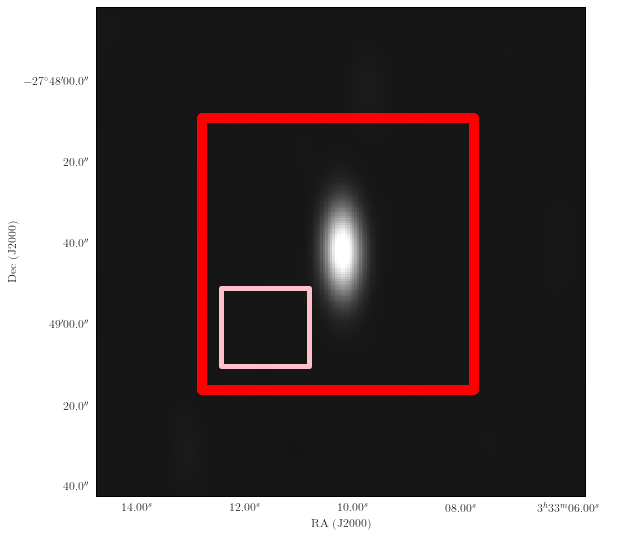

In [105]:
f = aplpy.FITSFigure('/Users/alger/data/RGZ/cdfs/2x2/CI0020_radio.fits')
f.show_grayscale()
f.show_rectangles(*f.pixel2world(100, 100), 2 * 0.56 / 60, 2 * 0.56 / 60, edgecolor='red', linewidth=10)
f.show_rectangles(*f.pixel2world(70, 70),
                  *numpy.abs(numpy.array(f.pixel2world(100, 100)) - numpy.array(f.pixel2world(132, 132))),
                  edgecolor='pink', linewidth=5)


(53.300339438393884, -27.818536047903606)